## About

This starter code shows how to read slides and tumor masks from the [CAMELYON16](https://camelyon17.grand-challenge.org/Data/) dataset. It will install [OpenSlide](https://openslide.org/) in Colab (the only non-Python dependency). Note that OpenSlide also includes a [DeepZoom viewer](https://github.com/openslide/openslide-python/tree/master/examples/deepzoom), shown in class. To use that, you'll need to install and run OpenSlide locally on your computer.

### Training data

The original slides and annotations are in an unusual format. I converted a bunch of them for you, so you can read them with OpenSlide as shown in this notebook. This [folder](https://drive.google.com/drive/folders/1rwWL8zU9v0M27BtQKI52bF6bVLW82RL5?usp=sharing) contains all the slides and tumor masks I converted (and these should be *plenty* for your project). If you'd like more beyond this, you'll need to use ASAP as described on the competition website to convert it into an appropriate format. 

Note that even with the starter code, it will take some effort to understand how to work with this data (the various zoom levels, and the coordinate system). Happy to help if you're stuck (please catch me in office hours, or right after class).

### Goals and grading

The goal for your project is to build a thoughtful, end-to-end prototype - not to match the accuracy from the [paper](https://arxiv.org/abs/1703.02442), and not necessarily to use all the available data. To receive an A on this work, your project should (for example):
- Use multiple zoom levels
- Use high-magnification images
- Include several visualizations of your results (both heatmaps showing predictions on individual slides, and other metrics/diagrams you design that are appropriate to communicate how well your model performs).

You are also welcome to propose a custom project of similar scope, happy to chat with you about your ideas anytime.

In [ ]:
# Install the OpenSlide C library and Python bindings
# After installing these libraries, use `Runtime -> restart and run all` on the menu
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libopenslide0
Suggested packages:
  libtiff-tools
The following NEW packages will be installed:
  libopenslide0 openslide-tools
0 upgraded, 2 newly installed, 0 to remove and 14 not upgraded.
Need to get 92.5 kB of archives.
After this operation, 268 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libopenslide0 amd64 3.4.1+dfsg-2 [79.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 openslide-tools amd64 3.4.1+dfsg-2 [12.7 kB]
Fetched 92.5 kB in 0s (208 kB/s)
Selecting previously unselected package libopenslide0.
(Reading database ... 144865 files and directories currently installed.)
Preparing to unpack .../libopenslide0_3.4.1+dfsg-2_amd64.deb ...
Unpacking libopenslide0 (3.4.1+dfsg-2) ...
Selecting previously unselected package openslide-tools.
Preparing to unpack 

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray
import random
import pandas as pd

# Generate Dataset

- Train, Validation, Test

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def make_dir(base_path, level):
    level_dir = f'{base_path}level{level}'
    if not os.path.exists(level_dir):
        os.mkdir(level_dir)
    train_image_dir = os.path.join(level_dir,'train_image/')
    train_mask_dir = os.path.join(level_dir,'train_mask/')

    val_image_dir = os.path.join(level_dir,'val_image/')
    val_mask_dir = os.path.join(level_dir,'val_mask/')

    test_image_dir = os.path.join(level_dir,'test_image/')
    test_mask_dir = os.path.join(level_dir,'test_mask/')

    if not os.path.exists(train_image_dir):
        os.mkdir(train_image_dir)
    if not os.path.exists(train_mask_dir):
        os.mkdir(train_mask_dir)
    if not os.path.exists(val_image_dir):
        os.mkdir(val_image_dir)
    if not os.path.exists(val_mask_dir):
        os.mkdir(val_mask_dir)    
    if not os.path.exists(test_image_dir):
        os.mkdir(test_image_dir)
    if not os.path.exists(test_mask_dir):
        os.mkdir(test_mask_dir)
    return(train_image_dir, train_mask_dir, val_image_dir, val_mask_dir, test_image_dir, test_mask_dir)

In [ ]:
base_path = '/content/'
train_image_dir5, train_mask_dir5, val_image_dir5, val_mask_dir5, test_image_dir5, test_mask_dir5 = make_dir(base_path, level = 5)
train_image_dir4, train_mask_dir4, val_image_dir4, val_mask_dir4, test_image_dir4, test_mask_dir4 = make_dir(base_path, level = 4)
train_image_dir3, train_mask_dir3, val_image_dir3, val_mask_dir3, test_image_dir3, test_mask_dir3 = make_dir(base_path, level = 3)

In [ ]:
# create a folder called 'Applied Deep Learning' in the Google Drive

!unzip -q '/content/drive/MyDrive/Applied Deep Learning/project/level4/train_mask.zip' -d /content/level4/train_mask/
!unzip -q '/content/drive/MyDrive/Applied Deep Learning/project/level4/train_image.zip' -d /content/level4/train_image/
!unzip -q '/content/drive/MyDrive/Applied Deep Learning/project/level4/val_mask.zip' -d /content/level4/val_mask/
!unzip -q '/content/drive/MyDrive/Applied Deep Learning/project/level4/val_image.zip' -d /content/level4/val_image/
!unzip -q '/content/drive/MyDrive/Applied Deep Learning/project/level4/test_mask.zip' -d /content/level4/test_mask/
!unzip -q '/content/drive/MyDrive/Applied Deep Learning/project/level4/test_image.zip' -d /content/level4/test_image/

!unzip -q '/content/drive/MyDrive/Applied Deep Learning/project/level5/train_mask.zip' -d /content/level5/train_mask/
!unzip -q '/content/drive/MyDrive/Applied Deep Learning/project/level5/train_image.zip' -d /content/level5/train_image/
!unzip -q '/content/drive/MyDrive/Applied Deep Learning/project/level5/val_mask.zip' -d /content/level5/val_mask/
!unzip -q '/content/drive/MyDrive/Applied Deep Learning/project/level5/val_image.zip' -d /content/level5/val_image/
!unzip -q '/content/drive/MyDrive/Applied Deep Learning/project/level5/test_mask.zip' -d /content/level5/test_mask/
!unzip -q '/content/drive/MyDrive/Applied Deep Learning/project/level5/test_image.zip' -d /content/level5/test_image/

!unzip -q '/content/drive/MyDrive/Applied Deep Learning/project/level3/train_mask.zip' -d /content/level3/train_mask/
!unzip -q '/content/drive/MyDrive/Applied Deep Learning/project/level3/train_image.zip' -d /content/level3/train_image/
!unzip -q '/content/drive/MyDrive/Applied Deep Learning/project/level3/val_mask.zip' -d /content/level3/val_mask/
!unzip -q '/content/drive/MyDrive/Applied Deep Learning/project/level3/val_image.zip' -d /content/level3/val_image/
!unzip -q '/content/drive/MyDrive/Applied Deep Learning/project/level3/test_mask.zip' -d /content/level3/test_mask/
!unzip -q '/content/drive/MyDrive/Applied Deep Learning/project/level3/test_image.zip' -d /content/level3/test_image/

unzip:  cannot find or open /content/drive/MyDrive/Applied Deep Learning/project/level3/train_mask.zip, /content/drive/MyDrive/Applied Deep Learning/project/level3/train_mask.zip.zip or /content/drive/MyDrive/Applied Deep Learning/project/level3/train_mask.zip.ZIP.
unzip:  cannot find or open /content/drive/MyDrive/Applied Deep Learning/project/level3/train_image.zip, /content/drive/MyDrive/Applied Deep Learning/project/level3/train_image.zip.zip or /content/drive/MyDrive/Applied Deep Learning/project/level3/train_image.zip.ZIP.
unzip:  cannot find or open /content/drive/MyDrive/Applied Deep Learning/project/level3/val_mask.zip, /content/drive/MyDrive/Applied Deep Learning/project/level3/val_mask.zip.zip or /content/drive/MyDrive/Applied Deep Learning/project/level3/val_mask.zip.ZIP.
unzip:  cannot find or open /content/drive/MyDrive/Applied Deep Learning/project/level3/val_image.zip, /content/drive/MyDrive/Applied Deep Learning/project/level3/val_image.zip.zip or /content/drive/MyDriv

In [ ]:
!cp '/content/drive/MyDrive/Applied Deep Learning/project/level4/level4_train_data.txt' /content/
!cp '/content/drive/MyDrive/Applied Deep Learning/project/level4/level4_val_data.txt' /content/
!cp '/content/drive/MyDrive/Applied Deep Learning/project/level4/level4_test_data.txt' /content/

!cp '/content/drive/MyDrive/Applied Deep Learning/project/level5/level5_train_data.txt' /content/
!cp '/content/drive/MyDrive/Applied Deep Learning/project/level5/level5_val_data.txt' /content/
!cp '/content/drive/MyDrive/Applied Deep Learning/project/level5/level5_test_data.txt' /content/

!cp '/content/drive/MyDrive/Applied Deep Learning/project/level3/level3_train_data.txt' /content/
!cp '/content/drive/MyDrive/Applied Deep Learning/project/level3/level3_val_data.txt' /content/
!cp '/content/drive/MyDrive/Applied Deep Learning/project/level3/level3_test_data.txt' /content/

In [ ]:
IMG_SIZE = 299
batch_size = 32
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# data generator
def data_generator(train_image_dir, val_image_dir, test_image_dir):
    train_datagen = ImageDataGenerator(rescale = 1./255)
    test_datagen = ImageDataGenerator(rescale = 1./255)
    # train set
    train_generator = train_datagen.flow_from_directory(
        train_image_dir,
        target_size = (IMG_SIZE, IMG_SIZE),
        batch_size = batch_size,
        class_mode = 'binary',
        shuffle=True,
        subset='training'
    )
    validation_generator = test_datagen.flow_from_directory(
        val_image_dir, 
        target_size = (IMG_SIZE, IMG_SIZE),
        batch_size = batch_size,
        class_mode = 'binary',
        shuffle=True,
        subset='validation'
    )

    for data_batch, labels_batch in train_generator:
        print('Train data: ')
        print('data batch shape:', data_batch.shape)
        print('labels batch shape:', labels_batch.shape)
        break

    for data_batch, labels_batch in validation_generator:
        print('\n')
        print('Validation data: ')
        print('data batch shape:', data_batch.shape)
        print('labels batch shape:', labels_batch.shape)
        break
    # test set
    test_generator = test_datagen.flow_from_directory(
        test_image_dir,
        target_size = (IMG_SIZE, IMG_SIZE),
        batch_size = batch_size,
        class_mode = 'binary'
    )
    return(train_generator, validation_generator, test_generator)

# data generator with augmentation
def data_generator_aug(train_image_dir, val_image_dir, test_image_dir):
    # train set
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=90,
        # width_shift_range=0.2,
        # height_shift_range=0.2,
        # shear_range=0.2,
        # zoom_range=0.2,
        horizontal_flip=True,
        validation_split=0.2)
    test_datagen = ImageDataGenerator(rescale = 1./255)
    # train set
    train_generator = train_datagen.flow_from_directory(
        train_image_dir,
        target_size = (IMG_SIZE, IMG_SIZE),
        batch_size = batch_size,
        class_mode = 'binary',
        shuffle=True,
        subset='training'
    )
    validation_generator = test_datagen.flow_from_directory(
        val_image_dir, 
        target_size = (IMG_SIZE, IMG_SIZE),
        batch_size = batch_size,
        class_mode = 'binary',
        shuffle=True,
        subset='validation'
    )

    for data_batch, labels_batch in train_generator:
        print('Train data: ')
        print('data batch shape:', data_batch.shape)
        print('labels batch shape:', labels_batch.shape)
        break

    for data_batch, labels_batch in validation_generator:
        print('\n')
        print('Validation data: ')
        print('data batch shape:', data_batch.shape)
        print('labels batch shape:', labels_batch.shape)
        break
    # test set
    test_generator = test_datagen.flow_from_directory(
        test_image_dir,
        target_size = (IMG_SIZE, IMG_SIZE),
        batch_size = batch_size,
        class_mode = 'binary'
    )
    return(train_generator, validation_generator, test_generator)

In [ ]:
# train_generator, validation_generator, test_generator = data_generator(train_image_dir4, val_image_dir4, test_image_dir4)
train_generator, validation_generator, test_generator = data_generator_aug(train_image_dir4, val_image_dir4, test_image_dir4)

# train_generator, validation_generator, test_generator = data_generator(train_image_dir5, val_image_dir5, test_image_dir5)
# train_generator_aug, validation_generator, test_generator = data_generator_aug(train_image_dir5, val_image_dir5, test_image_dir5)

Found 5564 images belonging to 2 classes.
Found 0 images belonging to 2 classes.
Train data: 
data batch shape: (32, 299, 299, 3)
labels batch shape: (32,)


Validation data: 
data batch shape: (0, 299, 299, 3)
labels batch shape: (0,)
Found 1341 images belonging to 2 classes.


In [ ]:
import tensorflow as tf
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu',
                                 input_shape = (IMG_SIZE, IMG_SIZE, 3)))
model.add(tf.keras.layers.MaxPooling2D())
# model.add(tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'))
# model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(2, activation = 'softmax'))

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

history = model.fit(
    train_generator,
    epochs = 5,
    validation_data = validation_generator
)

Epoch 1/5
174/174 [==============================] - 114s 619ms/step - loss: 7.4517 - accuracy: 0.8421
Epoch 2/5
 67/174 [==========>...................] - ETA: 1:05 - loss: 0.2578 - accuracy: 0.8802

KeyboardInterrupt: ignored

# VGG16 

In [ ]:
import tensorflow as tf

IMG_SIZE = 299
base_model = tf.keras.applications.VGG16(
    include_top = False,
    weights = 'imagenet',
    input_shape = (IMG_SIZE, IMG_SIZE, 3),
    pooling = None,
    classes = 2,
    classifier_activation = 'softmax',
)

# do not update the pretrained weights during training
base_model.trainable = False

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(2, activation='softmax')

# build a model to use the pretrained base
model = tf.keras.Sequential([
    base_model,
    global_average_layer,
    prediction_layer
])

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

58892288/58889256 [==============================] - 1s 0us/step


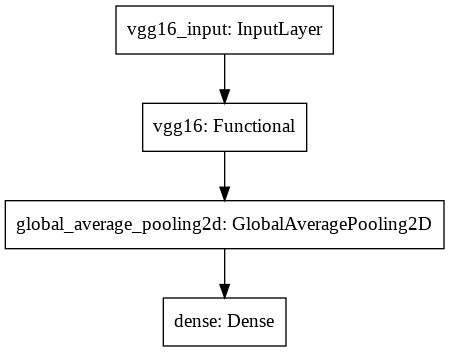

In [ ]:
tf.keras.utils.plot_model(model)

In [ ]:
if not os.path.exists('/content/checkpoint'):
  os.mkdir('/content/checkpoint')
if not os.path.exists('/content/checkpoint/VGG'):
  os.mkdir('/content/checkpoint/VGG')
vgg_checkpoint_path = '/content/checkpoint/VGG/weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5'
vgg_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(vgg_checkpoint_path, 
                                                               monitor='val_accuracy', 
                                                               save_best_only=True, 
                                                               mode='max')

In [ ]:
# vgg_early_stop_callback = tf.keras.callbacks.EarlyStopping(
#                               monitor='val_loss', min_delta=0, patience=3
#                           )

In [ ]:
history = model.fit(
    train_generator,
    epochs = 5,
    validation_data = validation_generator,
    callbacks=[vgg_checkpoint_callback]
)

Epoch 1/5
51/51 [==============================] - 16s 305ms/step - loss: 0.3488 - accuracy: 0.8495 - val_loss: 0.4369 - val_accuracy: 0.8486
Epoch 2/5
51/51 [==============================] - 16s 313ms/step - loss: 0.3403 - accuracy: 0.8495 - val_loss: 0.4358 - val_accuracy: 0.8511
Epoch 3/5
51/51 [==============================] - 17s 329ms/step - loss: 0.3331 - accuracy: 0.8545 - val_loss: 0.4391 - val_accuracy: 0.8511
Epoch 4/5
51/51 [==============================] - 17s 336ms/step - loss: 0.3264 - accuracy: 0.8557 - val_loss: 0.4399 - val_accuracy: 0.8437
Epoch 5/5
51/51 [==============================] - 17s 325ms/step - loss: 0.3215 - accuracy: 0.8625 - val_loss: 0.4414 - val_accuracy: 0.8437


In [ ]:
train_df = pd.read_csv('/content/level5_train_data.txt', header=None)
train_df.columns = ['Image Paths', 'Mask Paths', 'Xoffset', 'Yoffset', 'Labels', 'Level']

test_df = pd.read_csv('/content/level5_test_data.txt', header=None)
test_df.columns = ['Image Paths', 'Mask Paths', 'Xoffset', 'Yoffset', 'Labels', 'Level']

In [ ]:
test_loss = tf.keras.metrics.SparseCategoricalAccuracy(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

predictions = model.predict(test_generator)
true_labels = test_generator.labels
tumor_prob = predictions[:,1]
test_path_list = test_generator.filenames

test_loss(true_labels, predictions)
test_accuracy(true_labels, predictions)
print()

In [ ]:
y_pred = np.argmax(model.predict(test_generator), axis=-1)
y_true = true_labels

from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.55      0.91      0.69       198
           1       0.54      0.12      0.20       167

    accuracy                           0.55       365
   macro avg       0.55      0.52      0.44       365
weighted avg       0.55      0.55      0.46       365



In [ ]:
print("Test loss: {:.02f}\nTest accuracy: {:.02f}".format(test_loss.result(),
                                                          test_accuracy.result()*100))

Test loss: 0.51
Test accuracy: 50.68


In [ ]:
slide_code = '016'
slide_name = f'slide{slide_code}'
slide_df = test_df.iloc[list(map(lambda x: slide_name in x, test_df['Image Paths'])),:]
slide_df['test_image'] = slide_df['Image Paths'].map(lambda x:'/'.join(x.split('/')[-2:]))

slide_test_info = [(i, path) for i, path in enumerate(test_path_list) if slide_name in path]
slide_test_path = [path for i, path in slide_test_info]
slide_test_idx = [i for i, path in slide_test_info]
slide_test_tumor_prob = [tumor_prob[i] for i in slide_test_idx]
slide_test_result_df = pd.DataFrame({'path': slide_test_path, 'prob': slide_test_tumor_prob})
merge_df = pd.merge(slide_df, slide_test_result_df, how='left', left_on='test_image', right_on = 'path')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
data_path = '/content/drive/MyDrive/Applied Deep Learning/project/data/'

In [ ]:
slide_path = data_path + 'tumor_%s.tif' %slide_code
tumor_mask_path = data_path + 'tumor_%s_mask.tif' %slide_code
slide = open_slide(slide_path)
tumor_mask = open_slide(tumor_mask_path)

In [ ]:
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

In [ ]:
img_pred = Image.new('RGB', slide.level_dimensions[5])
img_true = Image.new('RGB', slide.level_dimensions[5])

patches_paths = [test_image_dir +'/' + path for path in merge_df['path'].to_list()]
mask_paths = [path.replace('level5/','') for path in merge_df['Mask Paths'].to_list()]
offsets = zip(merge_df.Xoffset.to_list(), merge_df.Yoffset.to_list())
labels = merge_df.Labels.to_list()
probs = merge_df.prob.to_list()

for patch_path, mask_path, offset, label, prob in zip(patches_paths, mask_paths, offsets, labels, probs):
    if prob >= 0.5:
      patch = Image.open(patch_path)
      patch = Image.blend(patch.convert("RGBA"), Image.new("RGBA", (299, 299)), 0.5)
      mask = Image.open(mask_path)
      mask = Image.blend(patch.convert("RGBA"),Image.new("RGBA", (299, 299), (192, 192, 192, 3)), 0.5)
      img_pred.paste(patch, box=offset)
      img_pred.paste(mask, box=offset)
    if label > 0:
      patch = Image.open(patch_path)
      patch = Image.blend(patch.convert("RGBA"), Image.new("RGBA", (299, 299)), 0.5)
      mask = Image.open(mask_path)
      mask = Image.blend(patch.convert("RGBA"),Image.new("RGBA", (299, 299), (192, 192, 192, 3)), 0.5)
      img_true.paste(patch, box=offset)
      img_true.paste(mask, box=offset)

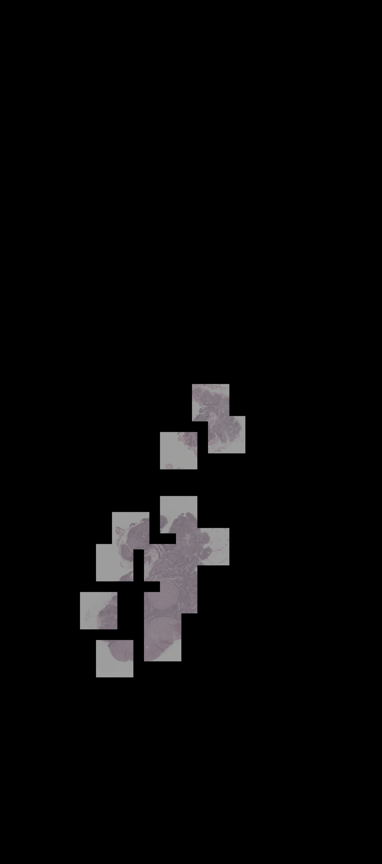

In [ ]:
img_pred.resize(map(lambda x: int(x / 8), img.size))

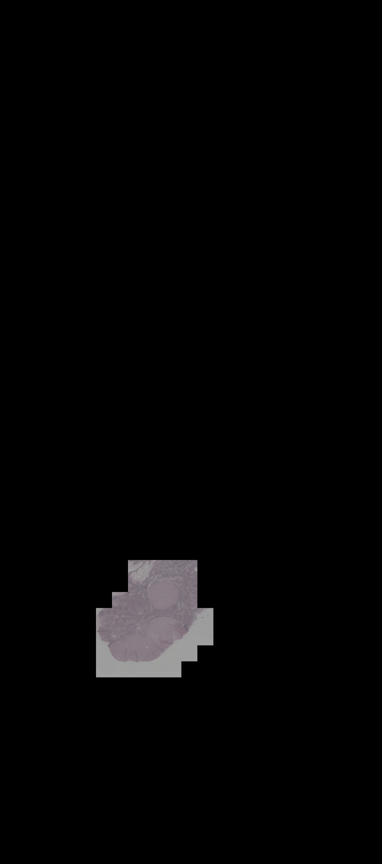

In [ ]:
img_true.resize(map(lambda x: int(x / 8), img.size))

## Data Augmentation

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=90,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    # shear_range=0.2,
    # zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)
train_generator = train_datagen.flow_from_directory(
    train_image_dir,
    target_size = (IMG_SIZE, IMG_SIZE),
    batch_size = batch_size,
    class_mode = 'binary',
    shuffle=True, 
    subset='training'
)
validation_generator = train_datagen.flow_from_directory(
    train_image_dir, 
    target_size = (IMG_SIZE, IMG_SIZE),
    batch_size = batch_size,
    class_mode = 'binary',
    shuffle=True, 
    subset='validation'
)


test_datagen = ImageDataGenerator(rescale = 1./255)
test_generator = test_datagen.flow_from_directory(
    test_image_dir,
    target_size = (IMG_SIZE, IMG_SIZE),
    batch_size = batch_size,
    class_mode = 'binary'
)

Found 1962 images belonging to 2 classes.
Found 490 images belonging to 2 classes.
Found 365 images belonging to 2 classes.


In [ ]:
history_aug = model.fit(
    train_generator,
    epochs = 30,
    validation_data = validation_generator
)

Epoch 1/30
62/62 [==============================] - 52s 834ms/step - loss: 0.2799 - accuracy: 0.8843 - val_loss: 0.4302 - val_accuracy: 0.8612
Epoch 2/30
62/62 [==============================] - 51s 818ms/step - loss: 0.2752 - accuracy: 0.8874 - val_loss: 0.4196 - val_accuracy: 0.8653
Epoch 3/30
62/62 [==============================] - 51s 823ms/step - loss: 0.2658 - accuracy: 0.8945 - val_loss: 0.4316 - val_accuracy: 0.8592
Epoch 4/30
62/62 [==============================] - 51s 826ms/step - loss: 0.2709 - accuracy: 0.8909 - val_loss: 0.4609 - val_accuracy: 0.8673
Epoch 5/30
62/62 [==============================] - 50s 813ms/step - loss: 0.2655 - accuracy: 0.8919 - val_loss: 0.4409 - val_accuracy: 0.8633
Epoch 6/30
62/62 [==============================] - 50s 813ms/step - loss: 0.2622 - accuracy: 0.9011 - val_loss: 0.4606 - val_accuracy: 0.8673
Epoch 7/30
62/62 [==============================] - 50s 806ms/step - loss: 0.2651 - accuracy: 0.8950 - val_loss: 0.4476 - val_accuracy: 0.8694

In [ ]:
test_loss = tf.keras.metrics.SparseCategoricalAccuracy(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

predictions = model.predict(test_generator)
true_labels = test_generator.labels
tumor_prob = predictions[:,1]
test_path_list = test_generator.filenames

test_loss(true_labels, predictions)
test_accuracy(true_labels, predictions)
print("Test loss: {:.02f}\nTest accuracy: {:.02f}".format(test_loss.result(),
                                                          test_accuracy.result()*100))

Test loss: 0.55
Test accuracy: 55.07


In [ ]:
slide_code = '016'
slide_name = f'slide{slide_code}'
slide_df = test_df.iloc[list(map(lambda x: slide_name in x, test_df['Image Paths'])),:]
slide_df['test_image'] = slide_df['Image Paths'].map(lambda x:'/'.join(x.split('/')[-2:]))

slide_test_info = [(i, path) for i, path in enumerate(test_path_list) if slide_name in path]
slide_test_path = [path for i, path in slide_test_info]
slide_test_idx = [i for i, path in slide_test_info]
slide_test_tumor_prob = [tumor_prob[i] for i in slide_test_idx]
slide_test_result_df = pd.DataFrame({'path': slide_test_path, 'prob': slide_test_tumor_prob})
merge_df = pd.merge(slide_df, slide_test_result_df, how='left', left_on='test_image', right_on = 'path')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
slide_path = data_path + 'tumor_%s.tif' %slide_code
tumor_mask_path = data_path + 'tumor_%s_mask.tif' %slide_code
slide = open_slide(slide_path)
tumor_mask = open_slide(tumor_mask_path)

In [ ]:
img_pred = Image.new('RGB', slide.level_dimensions[5])
img_true = Image.new('RGB', slide.level_dimensions[5])

patches_paths = [test_image_dir +'/' + path for path in merge_df['path'].to_list()]
mask_paths = [path.replace('level5/','') for path in merge_df['Mask Paths'].to_list()]
offsets = zip(merge_df.Xoffset.to_list(), merge_df.Yoffset.to_list())
labels = merge_df.Labels.to_list()
probs = merge_df.prob.to_list()

for patch_path, mask_path, offset, label, prob in zip(patches_paths, mask_paths, offsets, labels, probs):
    if prob >= 0.5:
      patch = Image.open(patch_path)
      patch = Image.blend(patch.convert("RGBA"), Image.new("RGBA", (299, 299)), 0.5)
      mask = Image.open(mask_path)
      mask = Image.blend(patch.convert("RGBA"),Image.new("RGBA", (299, 299), (192, 192, 192, 3)), 0.5)
      img_pred.paste(patch, box=offset)
      img_pred.paste(mask, box=offset)
    if label > 0:
      patch = Image.open(patch_path)
      patch = Image.blend(patch.convert("RGBA"), Image.new("RGBA", (299, 299)), 0.5)
      mask = Image.open(mask_path)
      mask = Image.blend(patch.convert("RGBA"),Image.new("RGBA", (299, 299), (192, 192, 192, 3)), 0.5)
      img_true.paste(patch, box=offset)
      img_true.paste(mask, box=offset)

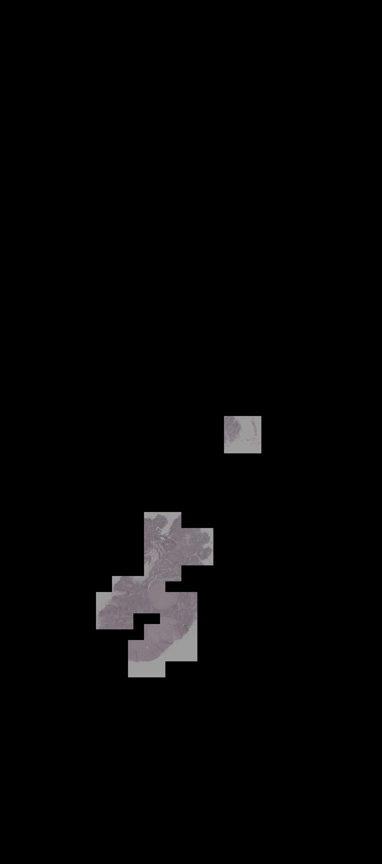

In [ ]:
img_pred.resize(map(lambda x: int(x / 8), img.size))

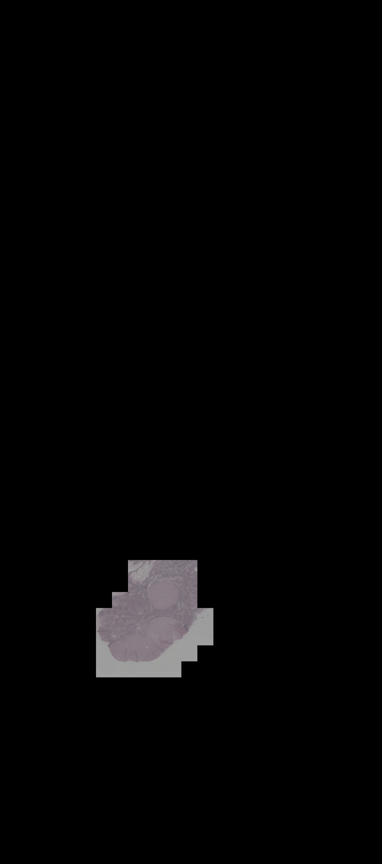

In [ ]:
img_true.resize(map(lambda x: int(x / 8), img.size))

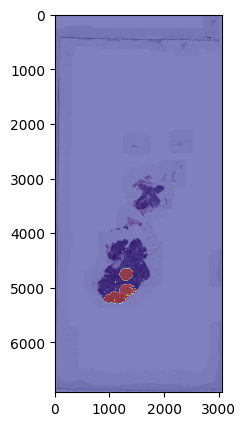

In [ ]:
level = 5
slide_image = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=level, 
                         width=slide.level_dimensions[level][0], 
                         height=slide.level_dimensions[level][1])
mask_image = read_slide(tumor_mask, 
                        x=0, 
                        y=0, 
                        level=level, 
                        width=slide.level_dimensions[level][0], 
                        height=slide.level_dimensions[level][1])
mask_image = mask_image[:,:,0]
plt.figure(figsize=(5,5), dpi=100)
plt.imshow(slide_image)
plt.imshow(mask_image, cmap='jet', alpha=0.5)

# InceptionV3

- with data augmentation

In [ ]:
IMG_SIZE = 299

base_model = tf.keras.applications.InceptionV3(include_top=False,
                                           weights='imagenet',
                                           input_shape=(IMG_SIZE, IMG_SIZE, 3))

for layer in base_model.layers:
    layer.trainable = False

inception_model = tf.keras.models.Sequential()
inception_model.add(base_model)
inception_model.add(tf.keras.layers.GlobalAveragePooling2D())
inception_model.add(tf.keras.layers.Dense(256, activation='relu'))
inception_model.add(tf.keras.layers.Dropout(rate = 0.4))
inception_model.add(tf.keras.layers.Dense(128, activation='relu'))
inception_model.add(tf.keras.layers.Dropout(rate = 0.4))
inception_model.add(tf.keras.layers.Dense(128, activation='relu'))
inception_model.add(tf.keras.layers.Dense(2, activation='softmax'))




inception_model.summary()

inception_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
                        loss = 'sparse_categorical_crossentropy',
                        metrics = ['accuracy'])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 8, 8, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_4 ( (None, 2048)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               524544    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)              

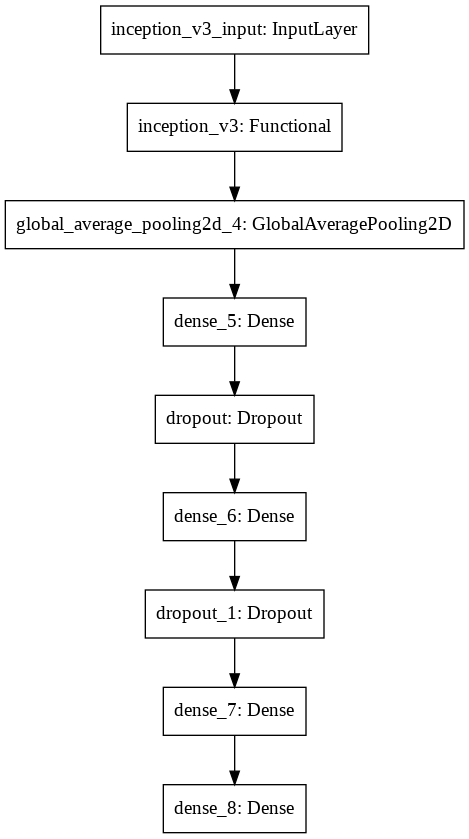

In [ ]:
tf.keras.utils.plot_model(inception_model)

In [ ]:
history_aug = inception_model.fit(
    train_generator,
    epochs = 30,
    validation_data = validation_generator
)

Epoch 1/100
62/62 [==============================] - 47s 764ms/step - loss: 0.3045 - accuracy: 0.8807 - val_loss: 0.4811 - val_accuracy: 0.8694
Epoch 2/100
62/62 [==============================] - 48s 772ms/step - loss: 0.2891 - accuracy: 0.8792 - val_loss: 0.4868 - val_accuracy: 0.8673
Epoch 3/100
62/62 [==============================] - 47s 764ms/step - loss: 0.2838 - accuracy: 0.8823 - val_loss: 0.5449 - val_accuracy: 0.8673
Epoch 4/100
62/62 [==============================] - 47s 767ms/step - loss: 0.2901 - accuracy: 0.8782 - val_loss: 0.4612 - val_accuracy: 0.8673
Epoch 5/100
62/62 [==============================] - 47s 766ms/step - loss: 0.2748 - accuracy: 0.8879 - val_loss: 0.4993 - val_accuracy: 0.8694
Epoch 6/100
62/62 [==============================] - 47s 765ms/step - loss: 0.2815 - accuracy: 0.8930 - val_loss: 0.5151 - val_accuracy: 0.8694
Epoch 7/100
62/62 [==============================] - 47s 766ms/step - loss: 0.2734 - accuracy: 0.8863 - val_loss: 0.5217 - val_accuracy:

KeyboardInterrupt: ignored

In [ ]:
test_loss = tf.keras.metrics.SparseCategoricalAccuracy(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

predictions = inception_model.predict(test_generator)
true_labels = test_generator.labels
tumor_prob = predictions[:,1]
test_path_list = test_generator.filenames

test_loss(true_labels, predictions)
test_accuracy(true_labels, predictions)
print("Test loss: {:.02f}\nTest accuracy: {:.02f}".format(test_loss.result(),
                                                          test_accuracy.result()*100))

Test loss: 0.53
Test accuracy: 52.88
